# Init

In [48]:
# IMPORT ALL LIB 
import subprocess
import numpy as np  
import matplotlib.pyplot as plt 

#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
print("pyvisa==",pyvisa.__version__)

pyvisa== 1.15.0


In [49]:
# The IP of the PC 
result = subprocess.run(["ipconfig"], capture_output=True, text=True)
output =result.stdout
arr=output.split("\n")
for i,l in enumerate (arr):
    if "Ethernet adapter Ethernet:" in l:
        break
for j in range(i,i+7):
    l= arr[j]
    print(l)

Ethernet adapter Ethernet:

   Connection-specific DNS Suffix  . : 
   Link-local IPv6 Address . . . . . : fe80::5481:6a10:a56d:aec%19
   Autoconfiguration IPv4 Address. . : 169.254.104.97
   Subnet Mask . . . . . . . . . . . : 255.255.0.0
   Default Gateway . . . . . . . . . : 


In [50]:
scope_ip = "169.254.104.98" 

In [51]:


def ping_oscilloscope(ip="169.254.229.238", count=1):
    try:
        result = subprocess.run(
            ["ping", "-n", str(count), ip],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # decode output as text
            shell=True
        )
        if result.returncode == 0:
            print("Ping successful:")
        else:
            print("Ping failed:")
        print(result.stdout)
    except Exception as e:
        print("Error pinging oscilloscope:", e)

ping_oscilloscope(ip = scope_ip )

Ping successful:

Pinging 169.254.104.98 with 32 bytes of data:
Reply from 169.254.104.98: bytes=32 time=1ms TTL=255

Ping statistics for 169.254.104.98:
    Packets: Sent = 1, Received = 1, Lost = 0 (0% loss),
Approximate round trip times in milli-seconds:
    Minimum = 1ms, Maximum = 1ms, Average = 1ms



In [52]:
rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  

 
resource_str = f"TCPIP::{scope_ip}::INSTR"  
try:  
    scope.close()  
except: pass  
try:  
    scope = rm.open_resource(resource_str)  
    print("Connected to:", scope.query("*IDN?"))  
except Exception as e:  
    print("Connection failed:", e)  

Connected to: TEKTRONIX,TDS 3034B,0,CF:91.1CT FV:v3.35 TDS3FFT:v1.00 TDS3TRG:v1.00



In [53]:
def det_data(chanel = "CH1"): 
    scope.write("DATA:SOURCE "+chanel)  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000")  
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    
    # Scale data  
    voltages = (wave - y_offset) * y_increment + y_origin  
    
    times = np.arange(len(voltages)) * x_increment + x_origin 
    return times, voltages
#det_data(chanel = "CH1")

In [54]:
def get_active_channels():
    active_channels = []
    for i in range(1, 5):  # assuming up to CH4
        try:
            response = scope.query(f"SELECT:CH{i}?").strip()
            if response in ['1', 'ON']:  # depending on oscilloscope
                active_channels.append(f"CH{i}")
        except Exception as e:
            print(f"Error querying CH{i}: {e}")
    return active_channels
chanels = get_active_channels()
#chanels

In [55]:
#chanels = ['CH1', 'CH2']
def get_probe_config(chanels): 
    #params = ["PROBe", "IMPEDANCE", "COUPLING"]
    params = ["PROBe", "IMPEDANCE", "COUPLING", 
              "OFFSET", "POSITION", "BANDWIDTH", "INVERT", "SCALE"]
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        for p in params: 
            try:
                dic[p]= scope.query(cu+":"+p+"?").replace("\n", "")
            except: pass
        DIC[c]= dic
    params = ["HORIZONTAL:MAIN:SCALE?", "WFMPRE:NR_Pt?"]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["general"]= dic


    params = [
        "TRIGger:STATE?",
        "TRIGger:MAIn:EDGE:SOURce?",
        "TRIGger:MAIn:EDGE:SLOPe?",
        "TRIGger:MAIn:EDGE:COUPling?",
        "TRIGger:MAIn:LEVel?"
    ]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["trigger"]= dic
    
    return DIC
#get_probe_config(chanels)

In [56]:
def get_meas():
    arr = {}
    for i in range(1,5):  
        data, status = scope.query(f"MEASurement:MEAS{i}:DATA?").split(',')  
        mtype = scope.query(f"MEASurement:MEAS{i}:TYPE?").strip()
        source = scope.query(f"MEASurement:MEAS{i}:SOURCE1?").strip()
        if int(status) ==0:  
            #print("#", source,mtype, data)  
            try:
                arr[source][mtype]=data
            except:
                arr[source] = {mtype:data}

    return arr
#get_meas()              

In [57]:
import json


def get_params_txt(title=None):
    chanels = get_active_channels()
    dic  =get_probe_config(chanels)
    dic["measurements"]= get_meas() 
    if title is not None: 
        # Save to JSON file
        with open(title+".json", "w") as f:
            json.dump(dic, f, indent=4)
    return dic 
#_= get_params_txt("test")
#_

In [58]:
import pandas as pd 
def get_signals(title):
    chanels = get_active_channels()
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        time, voltage = det_data(chanel = cu)
        DIC["time"]= time
        DIC[cu]= voltage
    df = pd.DataFrame(DIC)
    df.to_csv(title+".csv", index = False) 
    return df


# MEAS

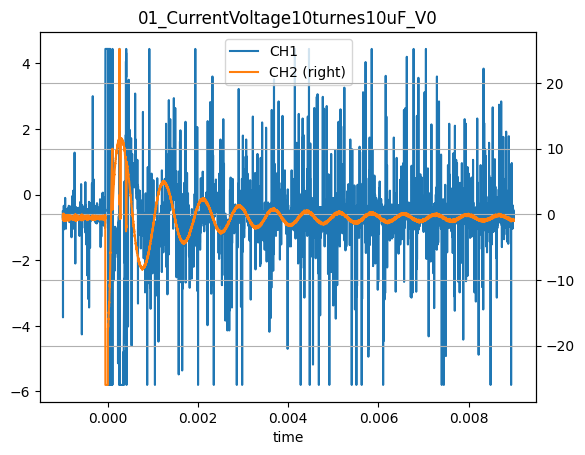

In [13]:
#read all chanels, parameters in one cmd 
title = "01_CurrentVoltage10turnes10uF_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

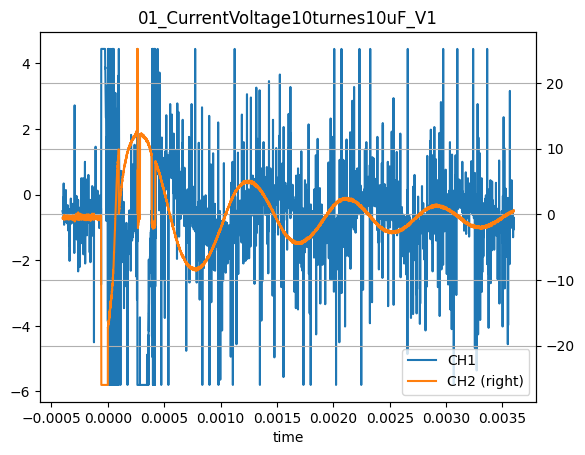

In [14]:
#read all chanels, parameters in one cmd 
title = "01_CurrentVoltage10turnes10uF_V1"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

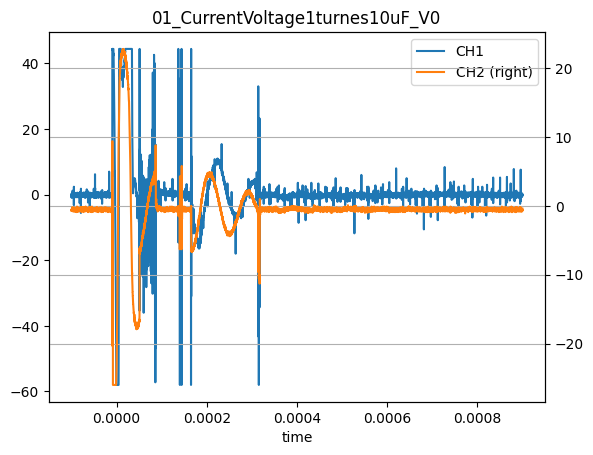

In [15]:
#read all chanels, parameters in one cmd 
title = "01_CurrentVoltage1turnes10uF_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

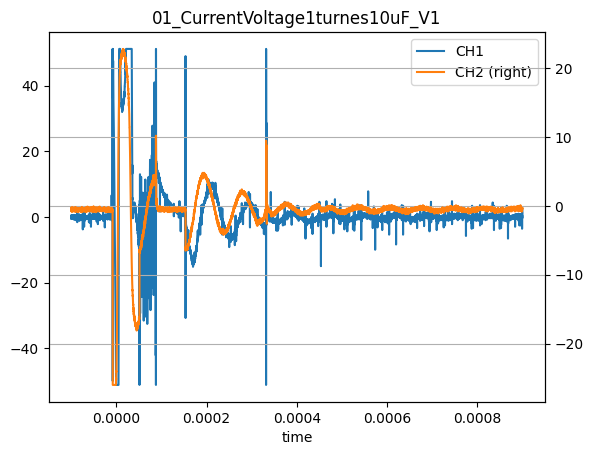

In [16]:
#read all chanels, parameters in one cmd 
title = "01_CurrentVoltage1turnes10uF_V1"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

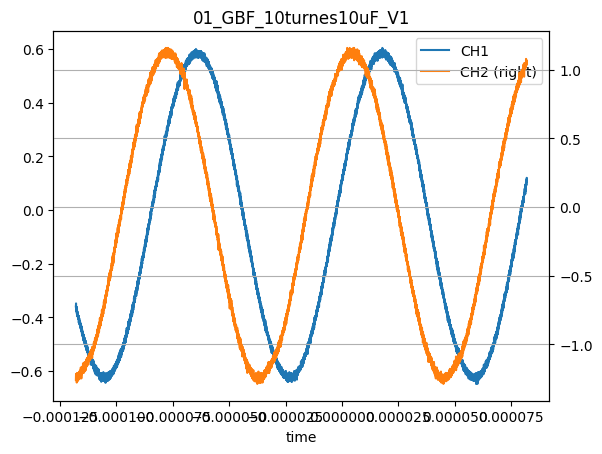

In [17]:
#read all chanels, parameters in one cmd 
title = "01_GBF_10turnes10uF_V1"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

In [23]:
import json

# Open and read the JSON file
with open("01_GBF_10turnes10uF_V1.json", "r") as file:
    data = json.load(file)

meas= data['measurements']
meas 

{'CH2': {'FREQUENCY': '1.2195E4', 'CRMS': '8.4335E-1', 'PHASE': '5.8566E1'},
 'CH1': {'CRMS': '4.2834E-1'}}

In [40]:
v2 = float(meas['CH2']['CRMS'])
v1 = float(meas['CH1']['CRMS'])
f= float (meas['CH2']['FREQUENCY'])
v1, v2, f

(0.42834, 0.84335, 12195.0)

In [41]:
from math import *
# V2= V1 * R/(R+ZL) 
# R+ZL = v1*R/v2
R=50
Vi, Vo = v2, v1
L= (Vi*R/Vo-R)/(2*pi*f)
N = 10 
AL = L/(N**2)
print(AL*1e9,"nH", L*1e6,"uH")

6322.346013382316 nH 632.2346013382316 uH


In [43]:
# Convert phase to radians
phase_deg= float (meas['CH2']['PHASE'])
phi = radians(phase_deg)

# Calculate inductance from phase
L = R * tan(phi) / (2 * pi * f)

# Calculate AL
AL = L / N**2

# Print results
print(f"L = {L*1e6:.2f} uH")
print(f"AL = {AL*1e9:.2f} nH")

L = 1067.61 uH
AL = 10676.10 nH


In [48]:
ALn=9600
print("error", 100*(AL*1e9-ALn)/ALn, "%")

error 11.209369615598726 %


In [49]:
AL*1e9,ALn

(10676.099483097478, 9600)

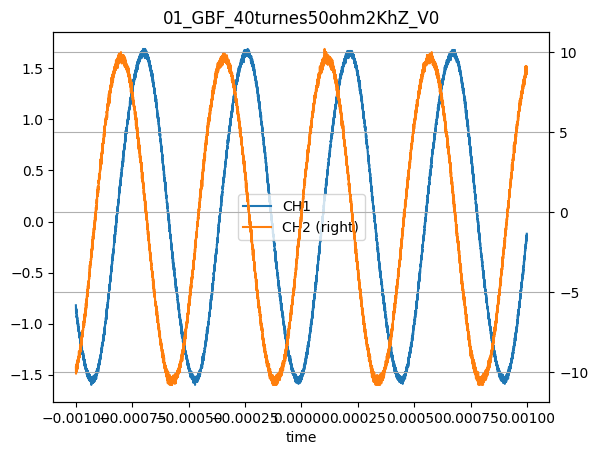

In [13]:
#read all chanels, parameters in one cmd 
title = "01_GBF_40turnes50ohm2KhZ_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

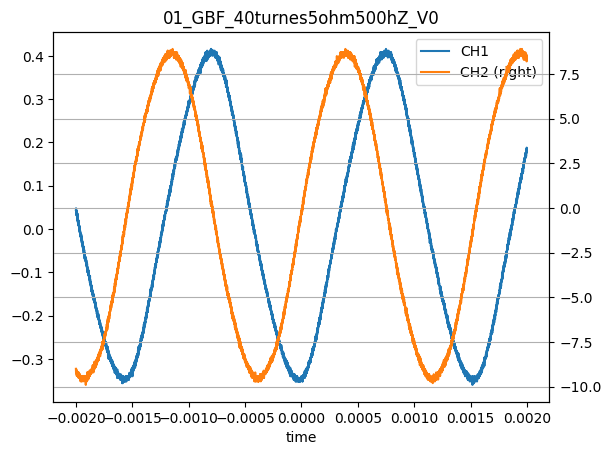

In [18]:
#read all chanels, parameters in one cmd 
title = "01_GBF_40turnes5ohm500hZ_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

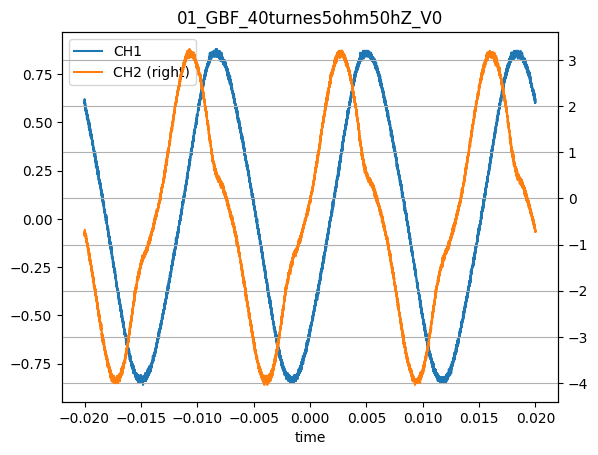

In [59]:
#read all chanels, parameters in one cmd 
title = "01_GBF_40turnes5ohm50hZ_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

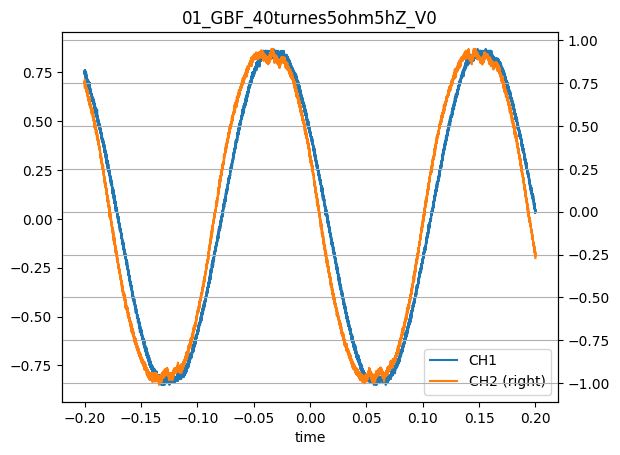

In [67]:
#read all chanels, parameters in one cmd 
title = "01_GBF_40turnes5ohm5hZ_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

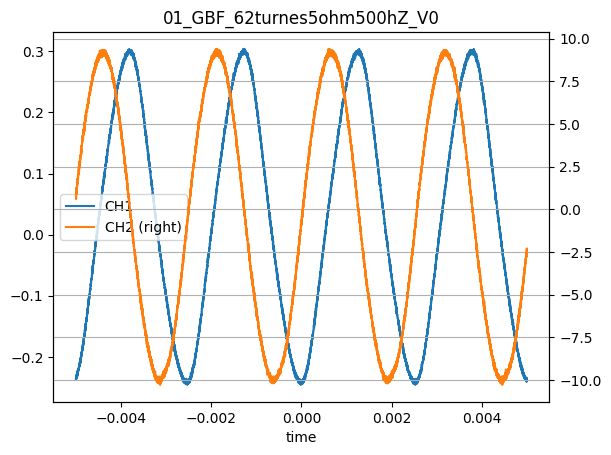

In [107]:
#read all chanels, parameters in one cmd 
title = "01_GBF_62turnes5ohm500hZ_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

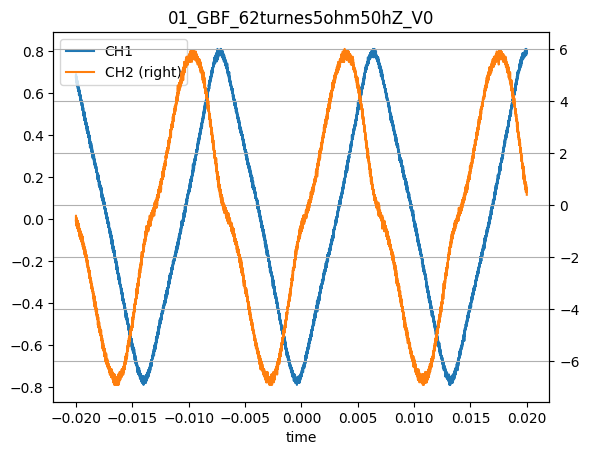

In [115]:
#read all chanels, parameters in one cmd 
title = "01_GBF_62turnes5ohm50hZ_V0"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

# Preprocessing

### Prepoc 1

In [16]:
import pandas as pd
df =pd.read_csv("01_GBF_40turnes50ohm2KhZ_V0.csv")
df.head()

,time,CH1,CH2
0,-0.001000,-0.82,-9.7
1,-0.001000,-0.86,-9.9
2,-0.001000,-0.86,-9.9
3,-0.001000,-0.89,-10.1
4,-0.000999,-0.86,-9.7


<Axes: xlabel='CH1'>

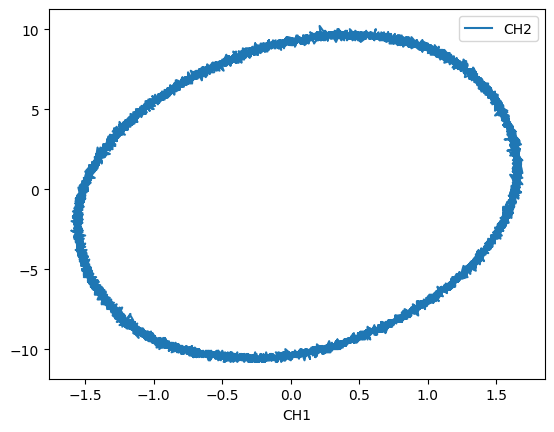

In [17]:
df.plot(x="CH1", y="CH2")

### Preproc 2

<Axes: xlabel='CH1'>

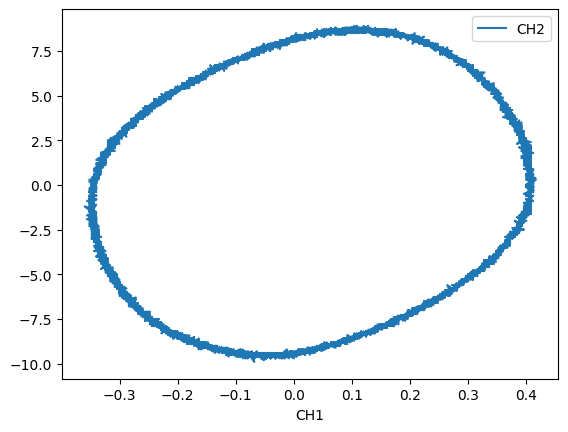

In [81]:
import pandas as pd
df =pd.read_csv("01_GBF_40turnes5ohm500hZ_V0.csv")
df.plot(x="CH1", y="CH2")

<Axes: xlabel='time'>

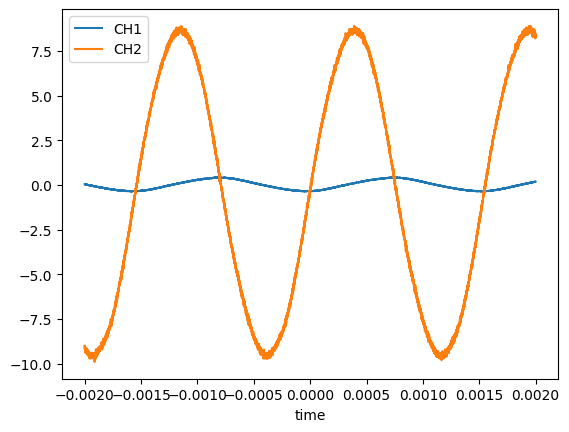

In [82]:
df.plot(x= "time", y=["CH1", "CH2"])

<Axes: >

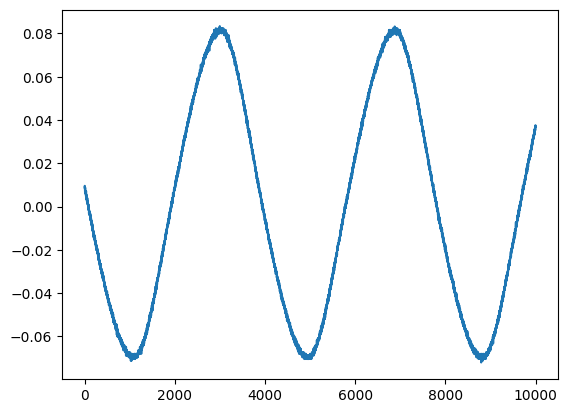

In [83]:
R=5
df["v"]=df.CH2-df.CH1
df["i"]=df.CH1/R
df.i.plot()

In [88]:
t= df.time.values
V= df.v.values
I= df.i.values

V=V-V.mean()
I= I-I.mean()

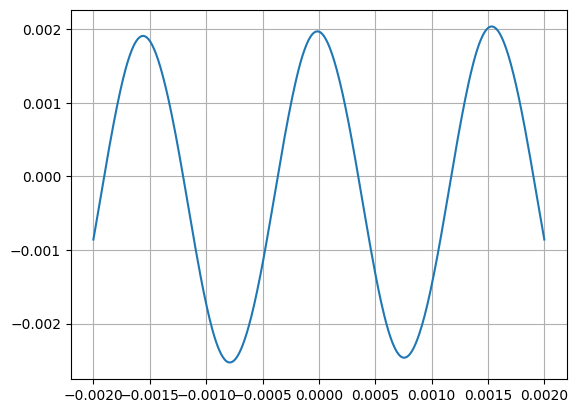

In [89]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V, t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()

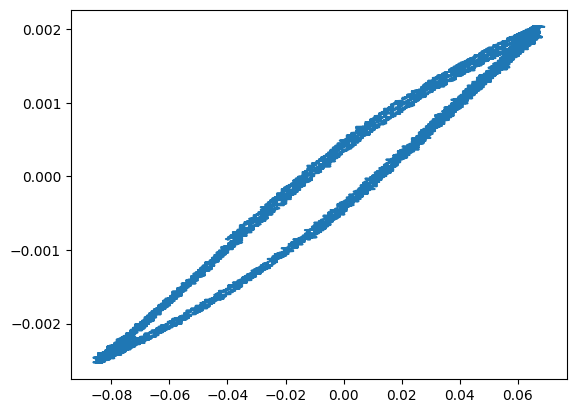

In [90]:
plt.plot(-I,phi)

Text(0, 0.5, 'B')

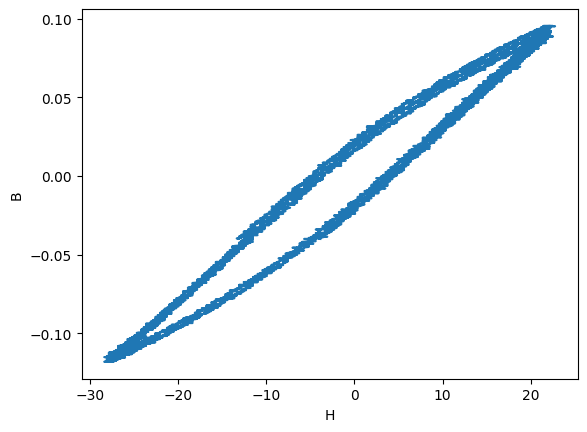

In [91]:
# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")

### Preproc 3

<Axes: xlabel='CH1'>

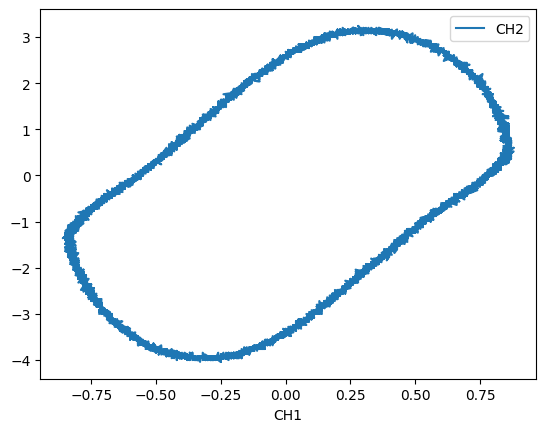

In [92]:
import pandas as pd
df =pd.read_csv("01_GBF_40turnes5ohm50hZ_V0.csv")
df.plot(x="CH1", y="CH2")

<Axes: xlabel='time'>

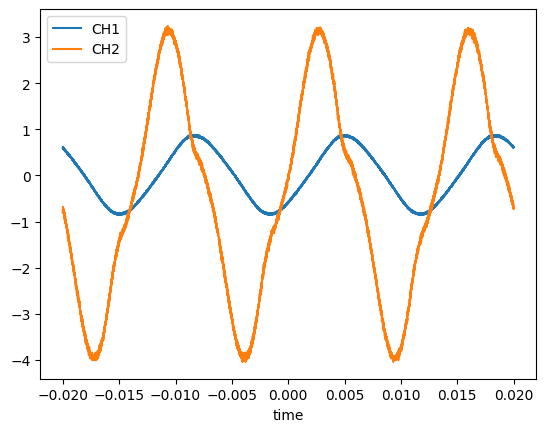

In [93]:
df.plot(x= "time", y=["CH1", "CH2"])

<Axes: >

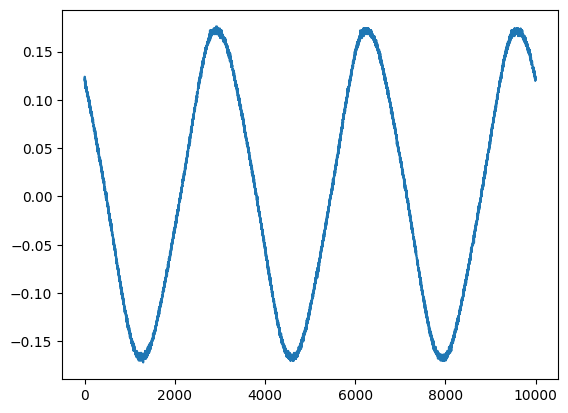

In [94]:
R=5
df["v"]=df.CH2-df.CH1
df["i"]=df.CH1/R
df.i.plot()

In [95]:
t= df.time.values
V= df.v.values
I= df.i.values

V=V-V.mean()
I= I-I.mean()

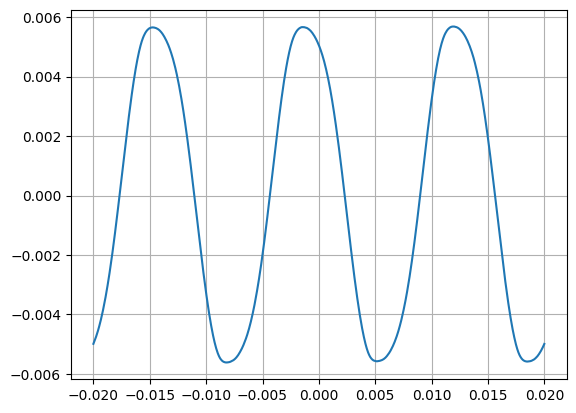

In [96]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V, t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()

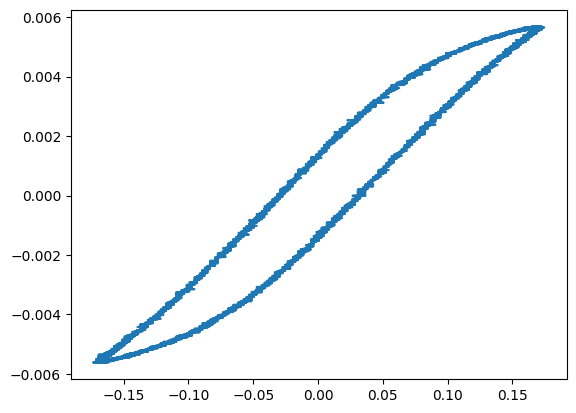

In [97]:
plt.plot(-I,phi)

Text(0, 0.5, 'B')

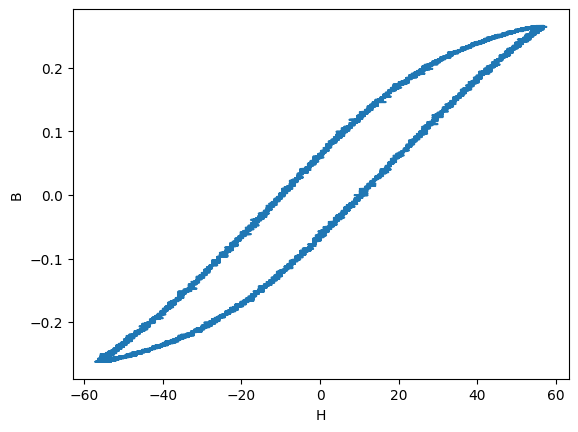

In [98]:
# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")

### Preproc 4

<Axes: xlabel='CH1'>

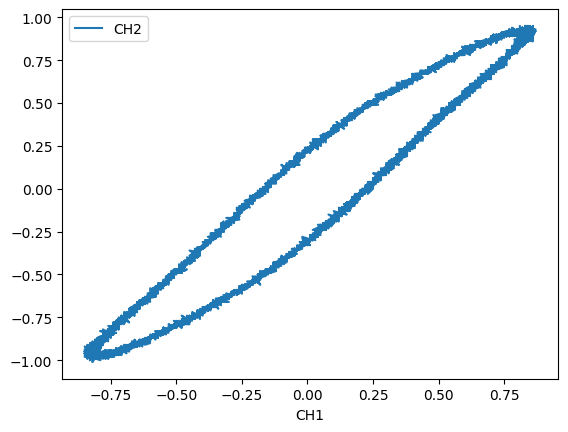

In [99]:
import pandas as pd
df =pd.read_csv("01_GBF_40turnes5ohm5hZ_V0.csv")
df.plot(x="CH1", y="CH2")

<Axes: xlabel='time'>

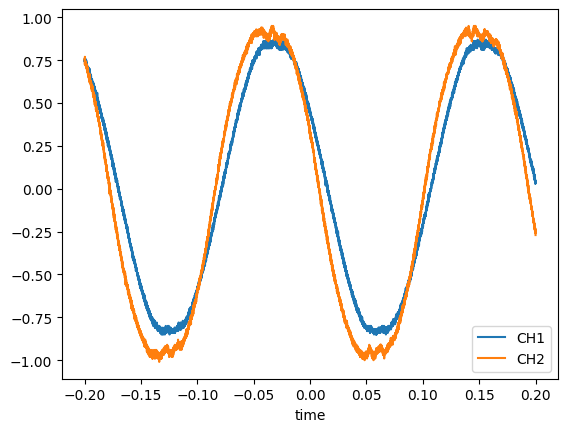

In [100]:
df.plot(x= "time", y=["CH1", "CH2"])

<Axes: >

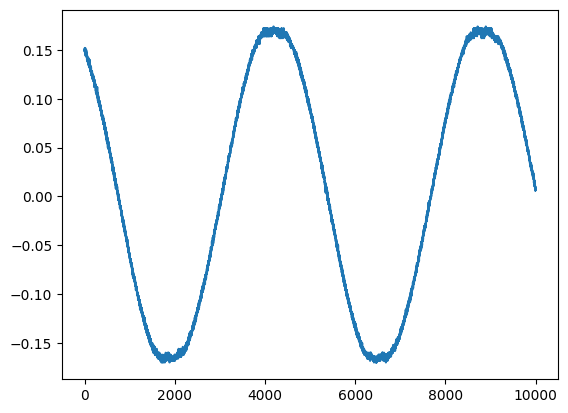

In [101]:
R=5
df["v"]=df.CH2-df.CH1
df["i"]=df.CH1/R
df.i.plot()

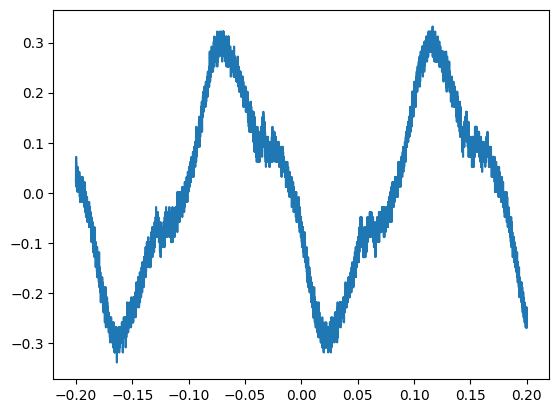

In [106]:
t= df.time.values
V= df.v.values
I= df.i.values

V=V-V.mean()
I= I-I.mean()
plt.plot(t, V)

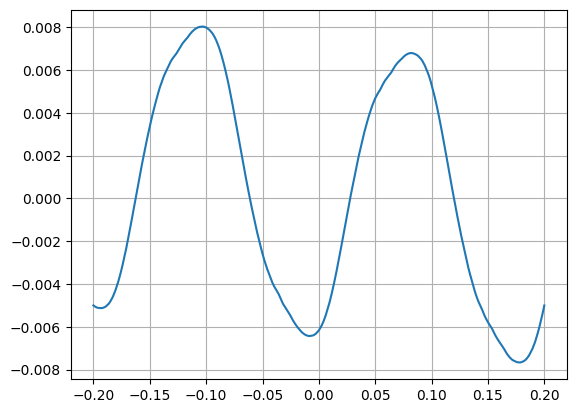

In [103]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V, t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()

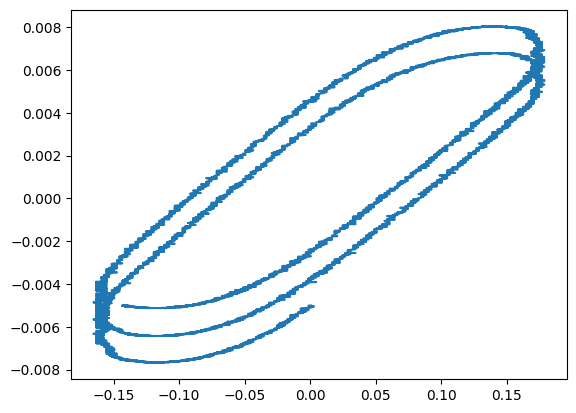

In [104]:
plt.plot(-I,phi)

Text(0, 0.5, 'B')

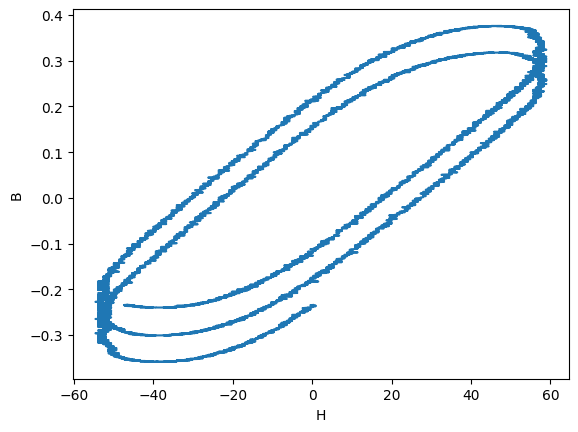

In [105]:
# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")

### Preproc 6

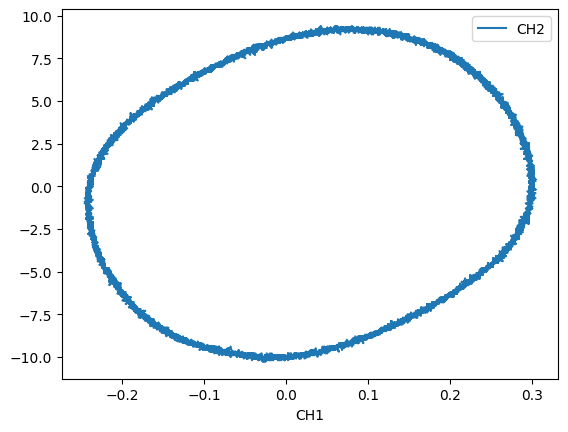

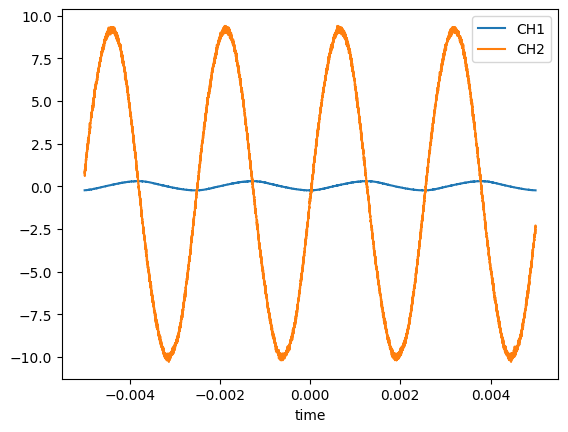

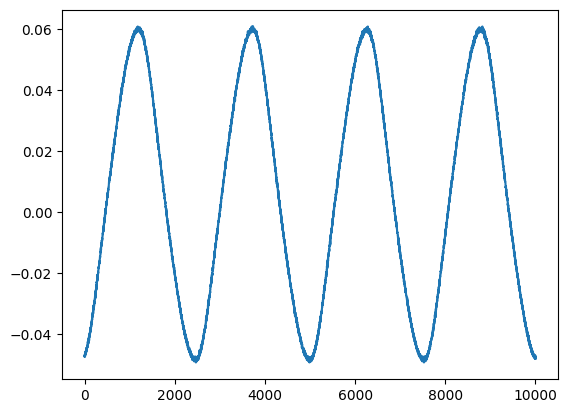

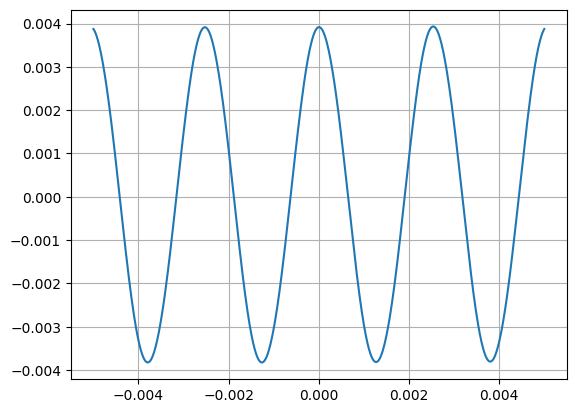

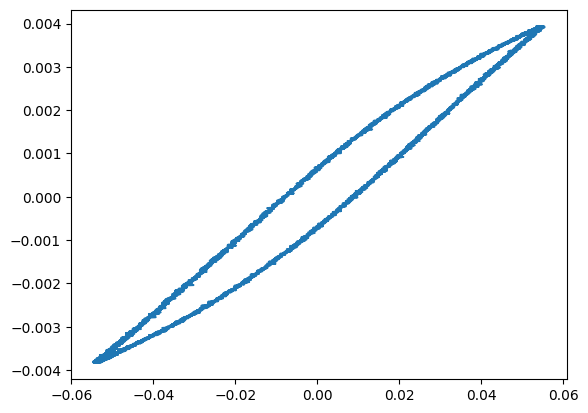

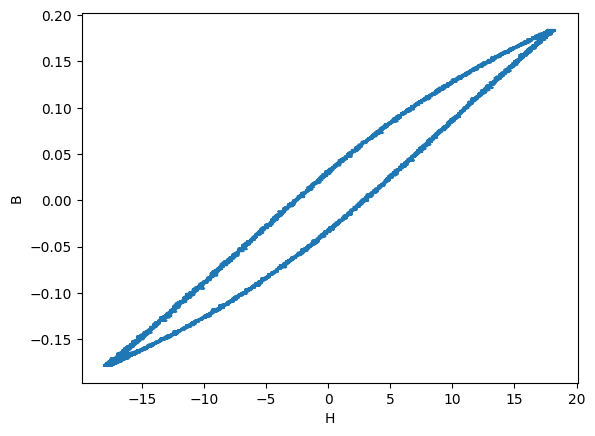

In [114]:
import pandas as pd
df =pd.read_csv("01_GBF_62turnes5ohm500hZ_V0.csv")
df.plot(x="CH1", y="CH2")

df.plot(x= "time", y=["CH1", "CH2"])
plt.show()

R=5
df["v"]=df.CH2-df.CH1
df["i"]=df.CH1/R
df.i.plot()
plt.show()

t= df.time.values
V= df.v.values
I= df.i.values

V=V-V.mean()
I= I-I.mean()

import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V, t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()
plt.show()

plt.plot(-I,phi)
plt.show()

# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")
plt.show()

### Preproc 7

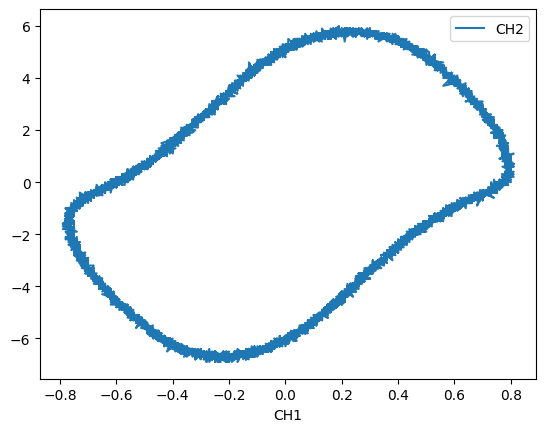

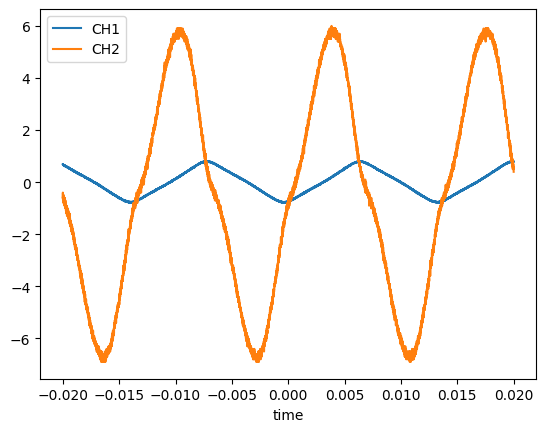

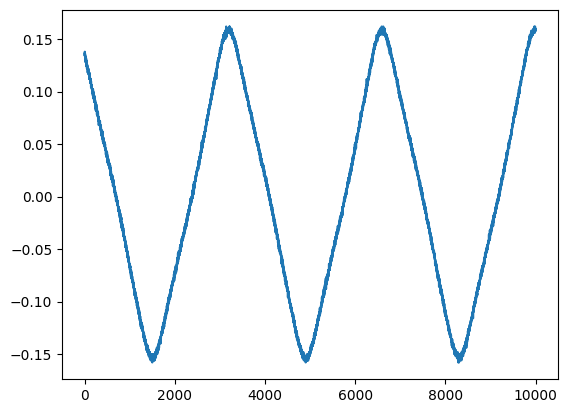

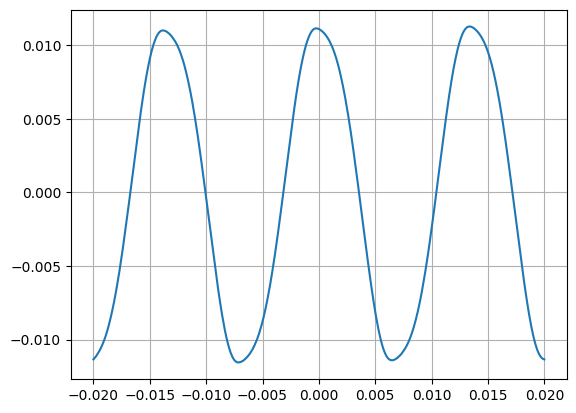

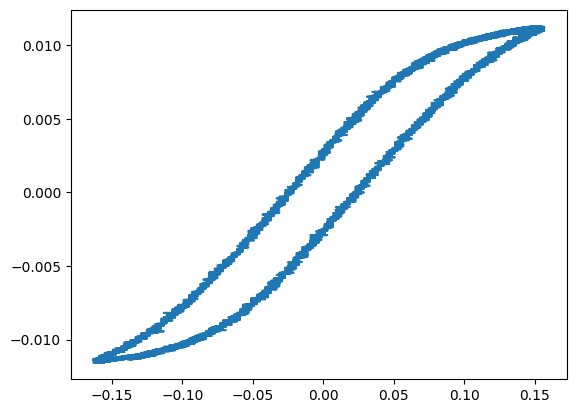

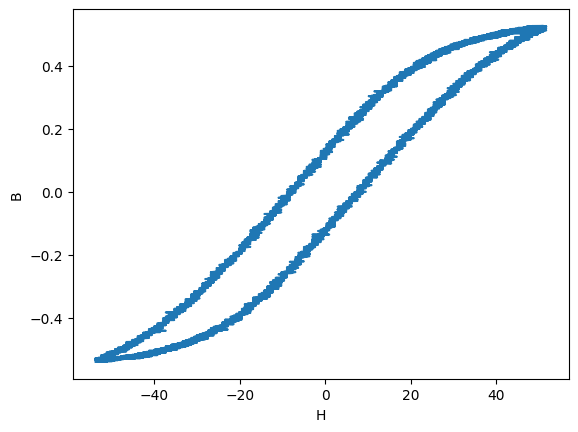

In [141]:
import pandas as pd
df =pd.read_csv("01_GBF_62turnes5ohm50hZ_V0.csv")
df.plot(x="CH1", y="CH2")

df.plot(x= "time", y=["CH1", "CH2"])
plt.show()

R=5
df["v"]=df.CH2-df.CH1
df["i"]=df.CH1/R
df.i.plot()
plt.show()

t= df.time.values
V= df.v.values
I= df.i.values

V=V-V.mean()
I= I-I.mean()

import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V, t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()
plt.show()

plt.plot(-I,phi)
plt.show()

# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")
plt.show()

$W_h = \oint H , dB$

$H$ = magnetic field strength (A/m)

$B$ = magnetic flux density (T)

$W_h$ = energy density per cycle (J/m³)

$P_h = f \cdot W_h \cdot V$

$V$ = volume of the magnetic material (m³)

$f$ = magnetization frequency (Hz)

$P_h$ = hysteresis loss (W)

In [142]:
window = 5  # number of points for moving average
H_smooth = np.convolve(H, np.ones(window)/window, mode='same')
threshold = 0.01 * np.max(np.abs(H_smooth))  # 1% of max H
crossings = np.where((H_smooth[:-1] < threshold) & (H_smooth[1:] >= threshold))[0]
crossings

array([ 706, 4104, 5761, 7499])

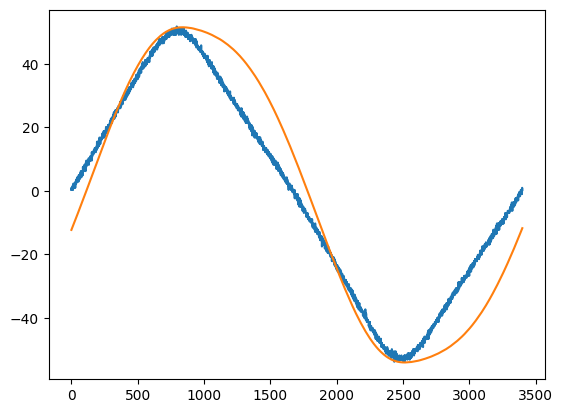

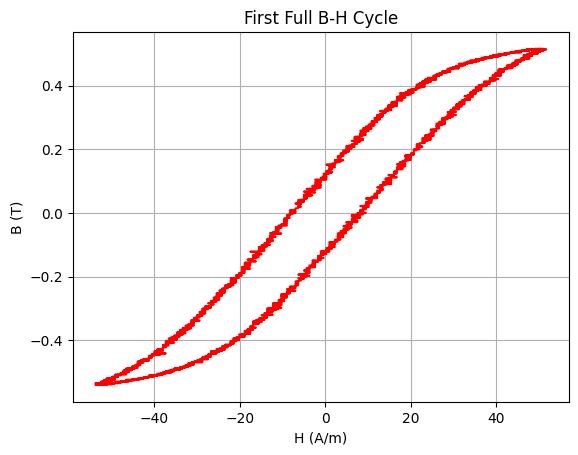

In [143]:
start = crossings[0]
end = crossings[1]

H_cycle = H[start:end+1]
B_cycle = B[start:end+1]
plt.plot(H_cycle)
plt.plot(100*B_cycle)
plt.show()
plt.plot(H_cycle, B_cycle, 'r')
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("First Full B-H Cycle")
plt.grid(True)
plt.show()


In [144]:
import numpy as np

# H_cycle and B_cycle are the arrays of one full cycle
#W_h = np.trapezoid(B_cycle, H_cycle)  # J/m³

W_h = np.abs(np.trapezoid(B_cycle, H_cycle))

print(f"Hysteresis energy per cycle: {W_h:.6f} J/m³")


Hysteresis energy per cycle: 15.401900 J/m³


In [145]:
# ELP 102/20/38 with I 102/7/38 N97
Ve = 67745 #mm3
Ve=Ve*1e-9
f=100e3
P_w = W_h*Ve*f
print(P_w, "W")
# 104.34017154581453 W

104.34017154581453 W


# DRAFT

### Preproc 3

<Axes: xlabel='CH1'>

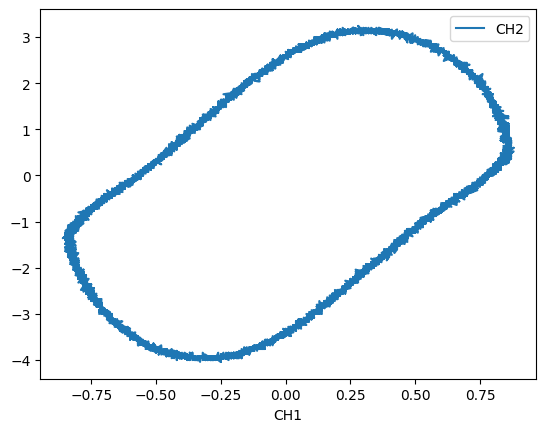

In [80]:
import pandas as pd
df =pd.read_csv("01_GBF_40turnes5ohm50hZ_V0.csv")
df.plot(x="CH1", y="CH2")

<Axes: xlabel='time'>

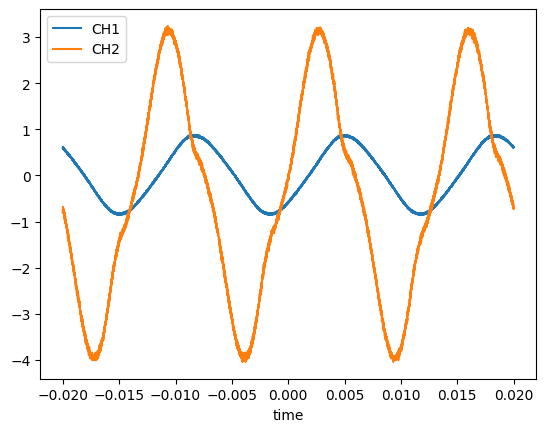

In [61]:
df.plot(x= "time", y=["CH1", "CH2"])

<Axes: >

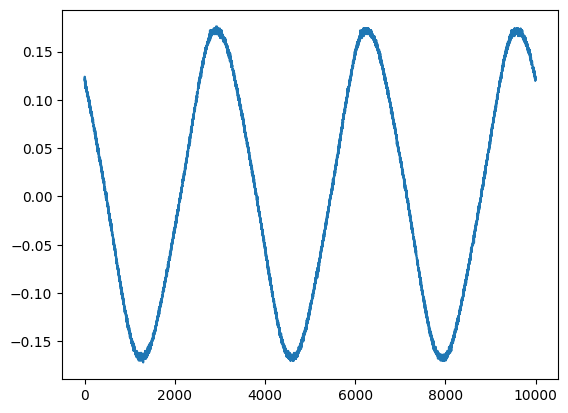

In [62]:
R=5
df["v"]=df.CH2
df["i"]=df.CH1/R
df.i.plot()

In [63]:
t= df.time.values
V= df.v.values
I= df.i.values

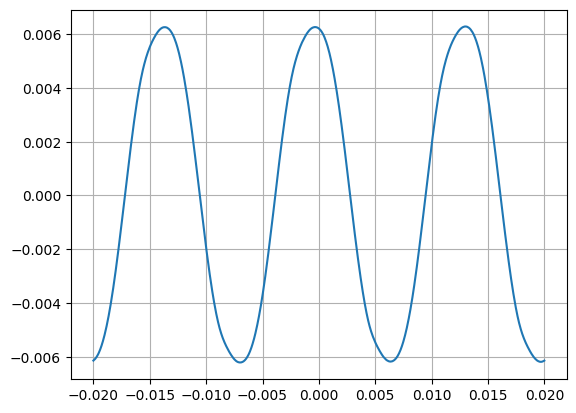

In [64]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V-V.mean(), t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()

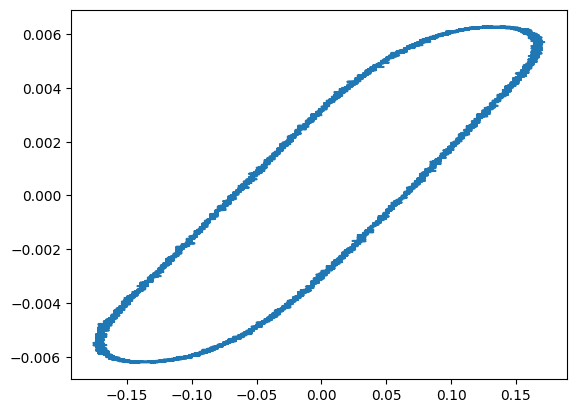

In [65]:
plt.plot(-I,phi)

Text(0, 0.5, 'B')

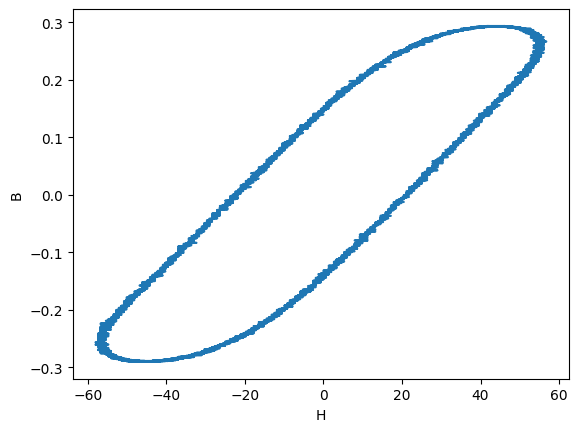

In [66]:
# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")

### Preproc 4

<Axes: xlabel='CH1'>

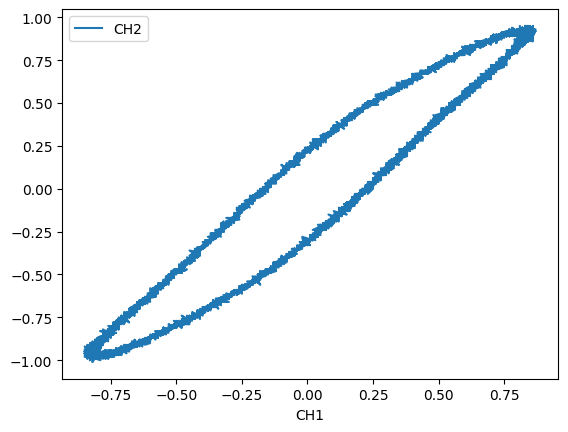

In [68]:
import pandas as pd
df =pd.read_csv("01_GBF_40turnes5ohm5hZ_V0.csv")
df.plot(x="CH1", y="CH2")

<Axes: xlabel='time'>

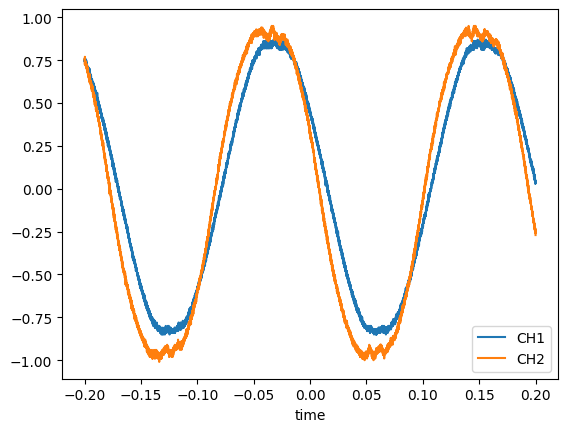

In [69]:
df.plot(x= "time", y=["CH1", "CH2"])

<Axes: >

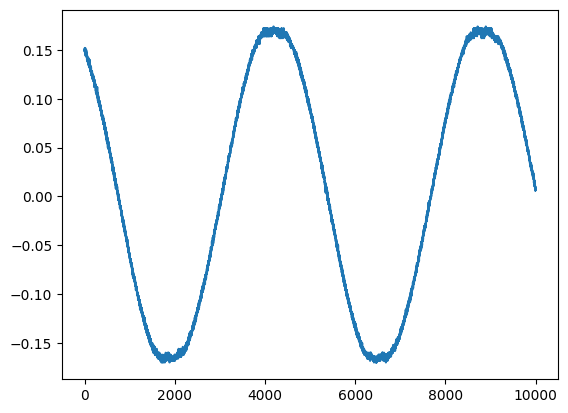

In [70]:
R=5
df["v"]=df.CH2
df["i"]=df.CH1/R
df.i.plot()

In [71]:
t= df.time.values
V= df.v.values
I= df.i.values

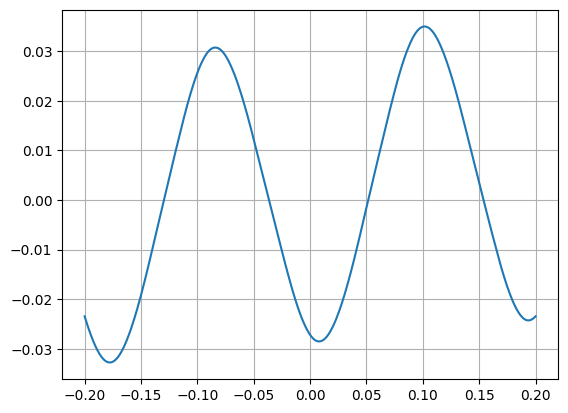

In [72]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

phi = -cumulative_trapezoid(V-V.mean(), t, initial=0)
phi = phi -phi.mean()

df["phi"]= phi 
plt.plot(t, phi)
plt.grid()

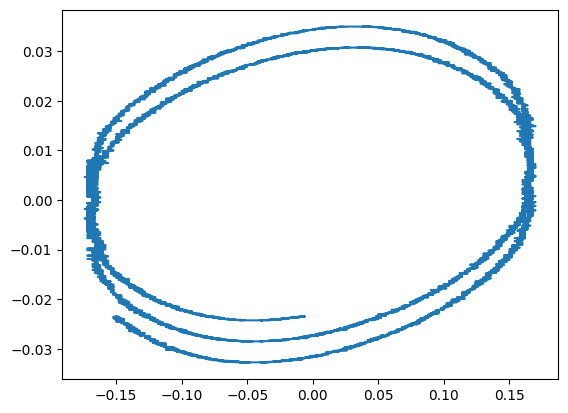

In [73]:
plt.plot(-I,phi)

Text(0, 0.5, 'B')

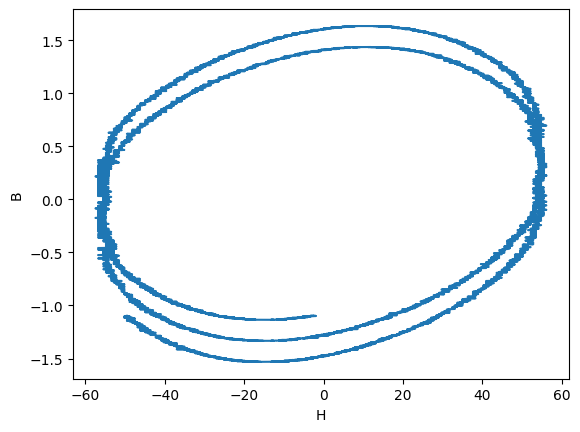

In [74]:
# Core geometry
le = 121.2e-3        # m
Ae = 534.2e-6        # m² (average)
Amin = 524.5e-6      # m² (minimum)
Ve = 67745e-9        # m³


N=40

H = -N* I / le  # A/m
B = phi / (N * Ae)  # Tesla
plt.plot(H,B)
plt.xlabel("H")
plt.ylabel ("B")